# CD4 Cropseq 1D effect size and WT coexpression analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [2]:
import functools

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/tfko140/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [56]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'1',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)

### Read the AnnData object

In [7]:
adata = sc.read(data_path + 'tfko.sng.guides.full.ct.h5ad')

Only considering the two last: ['.ct', '.h5ad'].
Only considering the two last: ['.ct', '.h5ad'].


In [8]:
adata.obs['guide1_cov'] = adata.obs['guide1_cov'].str.split('.').str[:-1].str.join('.')

### Pick out guides to test

In [9]:
counts = adata[adata.obs.WT == 'F'].obs.guide1_cov.value_counts()
filtered_guides = counts[counts > 500].index.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [10]:
wt_guides = adata[adata.obs.WT == 'T'].obs.guide1_cov.drop_duplicates().tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [11]:
filtered_guides = list(set(filtered_guides) - set(wt_guides))

In [12]:
len(filtered_guides)

145

### Filter guides by ChIP-seq availability

In [13]:
tfs = [guide.split('.')[0] for guide in filtered_guides]

In [14]:
encode_meta = pd.read_csv('encode_tf/metadata.tsv', sep='\t', header=0)
encode_files = pd.read_csv('encode_tf/files.txt', sep='\t', header=None)

encode_meta = encode_meta[encode_meta['Output type'].isin([ 'IDR thresholded peaks', 'optimal IDR thresholded peaks']) & (encode_meta['File assembly'] == 'GRCh38')]
encode_meta['target'] = encode_meta['Experiment target'].str.split('-').str[0]
encode_meta = encode_meta.sort_values('Output type', ascending=False).drop_duplicates('target').query('target in @tfs')
encode_meta = encode_meta[encode_meta['Audit ERROR'].isnull()]
encode_tfs = encode_meta.target.tolist()

In [15]:
filtered_guides = [g for g in filtered_guides if g.split('.')[0] in encode_tfs]

In [16]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

### Setup memento

In [17]:
adata.obs['q'] = 0.11

In [18]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Get differential expression result

In [19]:
result_1d = pd.read_csv(data_path + '1d/filtered_1d_result.csv').query('de_fdr < 0.1')

In [20]:
de_genes = {}
de_genes_by_gene = {}
results = {}
all_de_genes = set([])
for guide in filtered_guides:
    
    res = result_1d.query('tx == "{}"'.format(guide))
    de_genes[guide] = res.gene.tolist()
    results[guide] =res
    all_de_genes |= set(de_genes[guide])

### Make heatmap

In [21]:
heatmap = pd.read_csv(data_path + '1d/raw_1d_result.csv')
heatmap['tf'] = heatmap['tx'].str.split('.').str[0]

In [22]:
heatmap = heatmap.pivot_table('de_coef', 'tx', 'gene')

### Read DE genes

In [76]:
de_genes = {}
all_de_genes = set([])
all_available_genes = set([])
all_result = []
for guide in filtered_guides:
    
    res = result_1d.query('tx == "{}"'.format(guide)).copy()
    
    res['guide'] = guide
    res['de_fdr'] = memento.util._fdrcorrect(res['de_pval'])
    
    all_result.append(res)
    
    all_de_genes |= set(res.query('de_fdr < 0.05 & de_coef < 0').sort_values('de_coef').head(10).gene.tolist())
    
    if len(all_available_genes) == 0:
        all_available_genes = set(res.gene)
    else:
        all_available_genes &= set(res.gene)
        
all_result = pd.concat(all_result)

In [77]:
effect_size_heatmap = heatmap[list(all_de_genes)]

In [78]:
effect_size_heatmap.shape

(145, 414)

In [79]:
from sklearn.cluster import AgglomerativeClustering
gene_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=2).fit(effect_size_heatmap.T)
guide_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=2
                                          ).fit(effect_size_heatmap)


In [80]:
gene_order = []
gene_sets = {}
gene_color = []
for g_cluster in range(gene_clustering.labels_.max()+1):
    selector = np.where(gene_clustering.labels_==g_cluster)[0]
    gene_order += effect_size_heatmap.columns[selector].tolist()
    gene_sets[g_cluster] = effect_size_heatmap.columns[selector].tolist()
    gene_color += [sns.color_palette()[c] for c in gene_clustering.labels_[selector]]
guide_order = []
for guide_cluster in range(guide_clustering.labels_.max()+1):
    selector = np.where(guide_clustering.labels_==guide_cluster)[0]
    guide_order += effect_size_heatmap.index[selector].tolist()
    

In [81]:
simplified_guide_order = ['.'.join(c.split('.')[:2]) for c in guide_order]

effect_size_heatmap.index = ['.'.join(c.split('.')[:2]) for c in effect_size_heatmap.index]

In [88]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':1,
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)

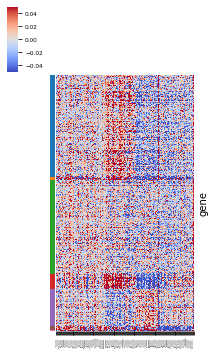

In [89]:
# plt.figure()
cg = sns.clustermap(
    effect_size_heatmap.T.loc[gene_order, simplified_guide_order],
    row_colors=gene_color,
    row_cluster=False,
    col_cluster=False,
    center=0, cmap='coolwarm', vmax=0.05, vmin=-0.05, xticklabels=1, yticklabels=False,
    cbar_kws={'shrink':0.5},figsize=(3,5))

cg.savefig('effect_size_heatmap.png', dpi=300, bbox_inches='tight')

In [412]:
effect_size_heatmap = pd.DataFrame(np.vstack(effect_size_heatmap), index=sig_filtered_guides, columns=de_genes_to_plot)

In [413]:
effect_size_heatmap.shape

(56, 674)

In [414]:
# cg = sns.clustermap(effect_size_heatmap.T, center=0, cmap='coolwarm', vmax=0.1, vmin=-0.1, figsize=(4, 10), method='complete', metric='euclidean')
# cg.ax_row_dendrogram.set_visible(False)
# cg.ax_col_dendrogram.set_visible(False)

In [415]:
from sklearn.cluster import AgglomerativeClustering
gene_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=4.5).fit(effect_size_heatmap.T)
guide_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=7
                                          ).fit(effect_size_heatmap)


In [416]:
pd.Series(guide_clustering.labels_).value_counts()

0    22
3    17
1    13
2     3
4     1
dtype: int64

In [417]:
pd.Series(gene_clustering.labels_).value_counts()

0    196
1    184
6    114
4    107
7     58
3      7
2      7
5      1
dtype: int64

In [433]:
gene_order = []
gene_sets = {}
gene_color = []
for g_cluster in range(gene_clustering.labels_.max()+1):
    selector = np.where(gene_clustering.labels_==g_cluster)[0]
    gene_order += effect_size_heatmap.columns[selector].tolist()
    gene_sets[g_cluster] = effect_size_heatmap.columns[selector].tolist()
    gene_color += [sns.color_palette()[c] for c in gene_clustering.labels_[selector]]
guide_order = []
for guide_cluster in range(guide_clustering.labels_.max()+1):
    selector = np.where(guide_clustering.labels_==guide_cluster)[0]
    guide_order += effect_size_heatmap.index[selector].tolist()
    

In [419]:
# cg = sns.clustermap(effect_size_heatmap.T, center=0, cmap='coolwarm', vmax=1, vmin=-1, z_score=1, figsize=(4, 10))
# cg.ax_row_dendrogram.set_visible(False)
# cg.ax_col_dendrogram.set_visible(False)

In [420]:
# order = cg.dendrogram_row.reordered_ind
# ordered_de_genes = list(np.array(de_genes_to_plot)[order])

In [421]:
# guide_order = cg.dendrogram_col.reordered_ind
# ordered_guides = list(np.array(sig_filtered_guides)[guide_order])

In [427]:
simplified_guide_order = ['.'.join(c.split('.')[:2]) for c in guide_order]

effect_size_heatmap.index = ['.'.join(c.split('.')[:2]) for c in effect_size_heatmap.index]

In [ ]:
# get gene colors

In [430]:
row_colors = [sns.color_palette()[c] for c in gene_clustering.labels_]

In [450]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

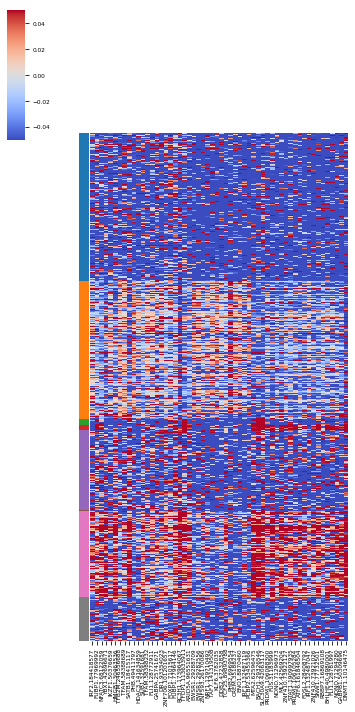

In [436]:
# plt.figure()
cg = sns.clustermap(
    effect_size_heatmap.T.loc[gene_order, simplified_guide_order],
    row_colors=gene_color,
    row_cluster=False,
    col_cluster=False,
    center=0, cmap='coolwarm', vmax=0.05, vmin=-0.05, xticklabels=1, yticklabels=False,
    cbar_kws={'shrink':0.5},figsize=(5,10))

cg.savefig('effect_size_heatmap.png', dpi=300, bbox_inches='tight')

### get genes

In [ ]:
for g in gene_sets[4]:
    print(g)

### WT coexpression

In [437]:
adata_wt = adata[adata.obs['WT'] == 'T'].copy().copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [438]:
adata_wt.obs['group'] = 'A'

In [439]:
memento.create_groups(adata_wt, label_columns=['group'])
memento.compute_1d_moments(adata_wt, gene_list=ordered_de_genes)

In [440]:
filtered_genes = [g for g in gene_order if g in adata_wt.var.index]
memento.compute_2d_moments(adata_wt, list(itertools.combinations(filtered_genes, 2)))
moments = memento.get_2d_moments(adata_wt, groupby='group')

In [441]:
gxg_matrix = pd.DataFrame(index=gene_order, columns=gene_order)
for idx, row in moments.iterrows():
    gxg_matrix.loc[row['gene_1'], row['gene_2']] = row['group_A']
    gxg_matrix.loc[row['gene_2'], row['gene_1']] = row['group_A']

(0.0, 674.0, 674.0, 0.0)

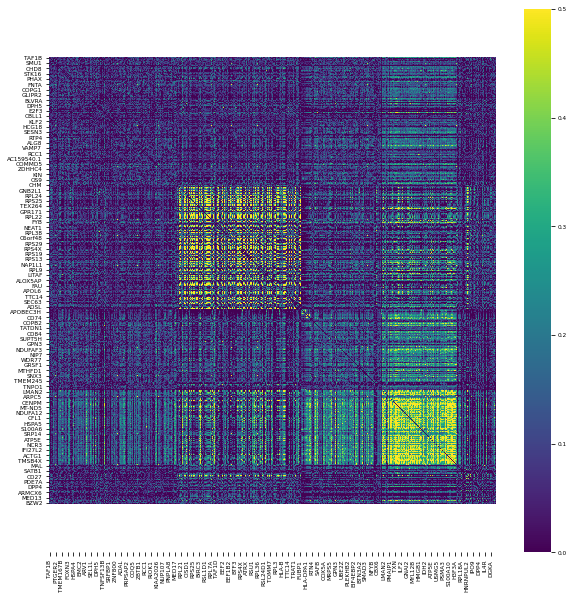

In [442]:
plt.figure(figsize=(10,10))
sns.heatmap(gxg_matrix.fillna(0).loc[gene_order, gene_order], cmap='viridis', vmin=0, vmax=0.5)
plt.axis('equal')

In [444]:
gxg_matrix.fillna(0.0).loc[gene_sets[5], gene_sets[5]]


,GNLY
GNLY,0.0


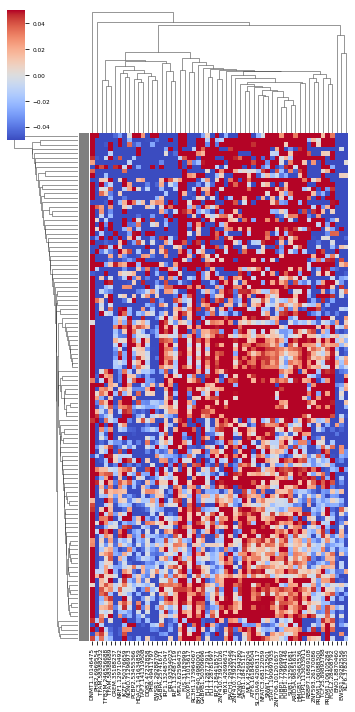

In [458]:
cg = sns.clustermap(
    effect_size_heatmap.T.loc[gene_sets[6], simplified_guide_order],
    row_colors=gene_color,

    center=0, cmap='coolwarm', vmax=0.05, vmin=-0.05, xticklabels=1, yticklabels=False,
    cbar_kws={'shrink':0.5},figsize=(5,10))

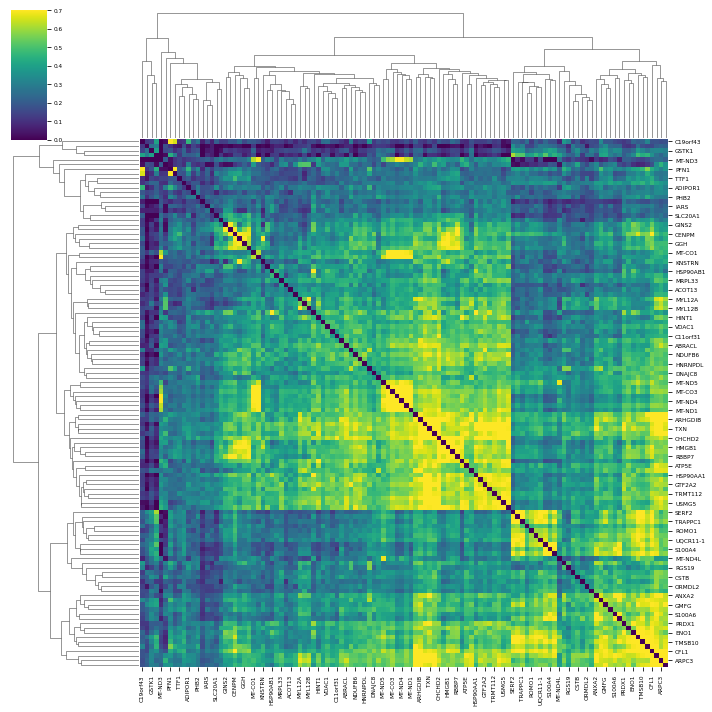

In [459]:
sns.clustermap(gxg_matrix.fillna(0.0).loc[gene_sets[6], gene_sets[6]], cmap='viridis', vmin=0, vmax=0.7)

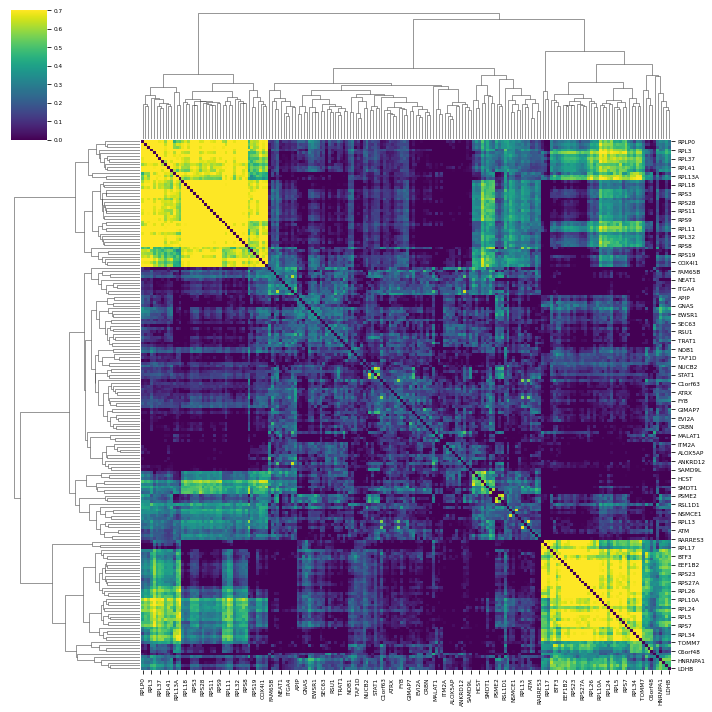

In [457]:
sns.clustermap(gxg_matrix.fillna(0.0).loc[gene_sets[1], gene_sets[1]], cmap='viridis', vmin=0, vmax=0.7)